In [1]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time
import sys

#for preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf

#for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#for evaluation
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import DataFrameSelector
from Utilities.utilities import CategoricalEncoder
from Utilities.utilities import display_scores
from Utilities.utilities import pipeline_transform
from Utilities.utilities import reset_graph
from Utilities.models import DNN_Model
from Utilities.models import cross_val_score_dnn
from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
from tensorflow.contrib.slim.nets import inception
import imagenet_helper_files.pnasnet as nas

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import get_file_lists
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.model_builder import build_dataset
from Utilities.bounded_model_builder import build_bounded_iterator
from Utilities.bounded_model_builder import build_bounded_iterator_points
from Utilities.model_builder import get_values_imagenet
from Utilities.model_builder import get_values_bounded
from Utilities.model_builder import get_values_bounded_points
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset

from Utilities.utilities import get_ground_truth_string
from Utilities.utilities import find_new_imagenet_ground_truth_int
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset
from Utilities.sample_counter import get_likelihood_avg
from Utilities.sample_counter import get_sample_number
from Utilities.sample_counter import get_likelihood_stdev

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond

c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Load the Data

Load the data, classes, and check that the tf_records are correct

In [2]:
#Location for all the training Data
#Set Variables

output_directory = "D:/Machine_Learning/Datasets/Cifar_80/tf_records"
labels_file = "D:/Machine_Learning/Datasets/Cifar_80/labels.txt"

output_directory_all = "D:/Machine_Learning/Datasets/Cifar_100/tf_records"
labels_file_all = "D:/Machine_Learning/Datasets/Cifar_100/labels.txt"


In [3]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data
class_file = open(labels_file,'r')
class_list = class_file.read().split('\n')

train_list, val_list = get_file_lists(output_directory)
labels = class_list

In [4]:
#Training and Validation data for all classs

class_file_all = open(labels_file_all,'r')
class_list_all = class_file_all.read().split('\n')
train_list_all, val_list_all = get_file_lists(output_directory_all)
labels_all = class_list_all

# Make sure the training Data is good

Here we will import a tf reccord and ensure the data is good

In [5]:
#Build a workflow to extract the data 
reset_graph()

filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_element = iterator.get_next()
X_data, y_data, file = next_element

X = tf.placeholder_with_default(X_data, [None,331,331,3])
y = tf.placeholder_with_default(y_data, [None])


In [6]:
#Test pulling a piece of data out of the set to ensure that records were created properly
with tf.Session() as sess:
    sess.run(train_iterator.initializer, feed_dict={filename: train_list_all, batch_size: 1, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())
    
    
    X_test, y_test, file_test = sess.run([X,y,file], feed_dict={handle: train_handle,training: False})

  

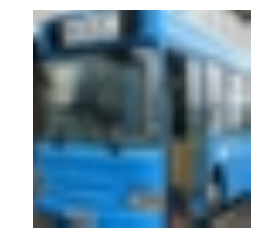

In [10]:
#Show and Image from set
x_val = X_test.reshape(331,331,3)

from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.axis('off')
plt.show()

In [11]:
x_val[1][1]

array([0.7965147 , 0.76184845, 0.7253599 ], dtype=float32)

In [8]:
#Check Class
labels_all[y_test[0]]

'bus'

In [9]:
#Check the file
file_test

array([b'188.png'], dtype=object)

# Build the Neural Network

Here we will build the Nas-Net and then stack our own network on top

In [5]:

#import pnas_net model

#Nasnet Model Location
nas_net_model = 'D:/AI/models/pnas_net/model.ckpt'

#directory for logs in training
out_of_set_net_logs = 'D:/AI/models/out_of_set_net_final/logs'
model_path = log_dir_build(out_of_set_net_logs, "out_of_set_final")

#directory for all the models saved during training
out_of_set_net_model_class = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_class'
out_of_set_net_model_tan = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_tan'
out_of_set_net_model_ae = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_ae'
out_of_set_net_best = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_best'


In [ ]:
#the graph 
reset_graph()

number_of_classes = 80

#Set up data Pipeline 
with tf.name_scope("Data_Retriever"):
    filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
    batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
    num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
    training = tf.placeholder_with_default(True, shape=(), name = 'training')
    handle = tf.placeholder(tf.string, shape=[], name="Dataset")

    training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)
    val_set = build_dataset(False, filename, batch_size, num_epochs, num_parallel_calls=8)

    train_iterator = training_set.make_initializable_iterator()
    val_iterator = val_set.make_initializable_iterator()



    iterator = tf.data.Iterator.from_string_handle(
        handle, training_set.output_types, training_set.output_shapes)
    next_data = iterator.get_next()
    X_data, y_data, file = next_data
    X = tf.placeholder_with_default(X_data, shape=[None,331,331,3], name="Image_Data")
    y = tf.placeholder_with_default(y_data, shape=[None], name="Max_Class_Int")


with tf.name_scope("BN_Layer_AE_Layers"):
    #Define initalizer and batch normalization layers
    bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
    he_init = tf.contrib.layers.variance_scaling_initializer()

with slim.arg_scope(inception.inception_v3_arg_scope()):
    net, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
    
    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")
    
    #Load in the noder where we are going to connect our own network
    last_feature_node = tf.layers.flatten(tf.get_default_graph().get_tensor_by_name("InceptionV3/Logits/Dropout_1b/Identity:0"))


with tf.name_scope("Out_Of_Set_Classifier"):
    #Use a stop layer to freeze all the layers beneath in Nas-Net
 
    with tf.name_scope("Isolate_Image_Features"):

        cnn_code_layer = tf.stop_gradient(last_feature_node)
        
    with tf.name_scope("Classifier"):
       
        #Set constants for Classifier
        dropout_rate = 0.2
        n_hidden1 = 1000
        n_hidden2 = 500
        n_final_layer = number_of_classes
        learning_rate_class = .01
        
        """ 
        with tf.name_scope("Class_Hidden_Layer_1"):
            hidden1_cat = tf.layers.dense(cnn_code_layer, n_hidden1, name="hidden1_cat", kernel_initializer=he_init)
            hidden1_drop = tf.layers.dropout(hidden1_cat, dropout_rate, training=training)
            bn1_cat = bn_batch_norm_layer(hidden1_drop)
            bn1_act_cat = tf.nn.relu(bn1_cat)        
        """


        with tf.name_scope("Class_Hidden_Layer_3"):
            hidden3_cat = tf.layers.dense(last_feature_node, n_hidden2, name="hidden2_cat", kernel_initializer=he_init)
            hidden3_drop = tf.layers.dropout(hidden3_cat, dropout_rate, training=training)
            bn3_cat = bn_batch_norm_layer(hidden3_drop)
            bn3_act_cat = tf.nn.relu(bn3_cat) 
  
        
        with tf.name_scope("Final_Layer"): 
            logits_before_bn = tf.layers.dense(bn3_act_cat, n_final_layer, name="outputs")
            logits = bn_batch_norm_layer(logits_before_bn, name="logits")
            softmax = tf.nn.softmax(logits, name="final_soft_max")
            max_softmax_val = tf.argmax(softmax,axis=1,name="softmax_Category_int",output_type=tf.int32)
            stop_max = tf.stop_gradient(max_softmax_val, name="Stop_Max")


        with tf.name_scope("loss"):
                xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
                loss_cat = tf.reduce_mean(xentropy, name="loss_cat")
                loss_summary_cat = tf.summary.scalar('loss_summary_cat', loss_cat)
            
        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False, name='global_step')
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(extra_update_ops):
                training_op = optimizer.minimize(loss_cat, global_step=global_step)


        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
    
    saver_class = tf.train.Saver(name="Class_Saver")
    
            
    with tf.name_scope("Autoencoder"):
        n_hidden4 = 108
        ae_learning_rate = 1
        cnn_code_layer_size = 2048
        with tf.name_scope("Original_Coding"):
            ae_code_layer = cnn_code_layer
            batch_mean = tf.expand_dims(tf.reduce_mean(cnn_code_layer,0),0)
            ae_code_normalized = tf.subtract(ae_code_layer, batch_mean)
            
        with tf.name_scope("PCA_Layer"):
            reduction_matrix = tf.Variable(tf.random_normal([cnn_code_layer_size, n_hidden4],stddev=.1),name="weights")           
            AutoCode = tf.matmul(ae_code_normalized,reduction_matrix)
            AutoOutput = tf.stop_gradient(AutoCode, name="Autoencoder_Output")
            
        
        with tf.name_scope("Reconstruction_Layer_Final"):
            final_layer = tf.layers.dense(AutoCode, cnn_code_layer_size, name="Reconstruction_Layer", 
                                                       kernel_initializer=he_init)
            final_reconstruction_layer_bn = tf.matmul(AutoCode, tf.transpose(reduction_matrix))
            final_reconstruction_layer = tf.add(final_reconstruction_layer_bn,batch_mean)
            
        with tf.name_scope("AutoEncoder_Loss"):
            ae_loss = tf.losses.mean_squared_error(final_reconstruction_layer,ae_code_layer)
            ae_loss_summary = tf.summary.scalar('ae_loss_summary', ae_loss)
            
           
        with tf.name_scope("AutoEncoder_Train"):
            
            ae_optimizer = tf.train.AdamOptimizer(learning_rate=ae_learning_rate)
            ae_global_step = tf.Variable(0, trainable=False, name='ae_global_step')
            training_op_ae = ae_optimizer.minimize(ae_loss, global_step=ae_global_step)
 
    saver_ae = tf.train.Saver(name="AutoEncoder_Saver")
            
    with tf.name_scope("Tan"):
        likely_batch_size = 60
        
        with tf.name_scope("Sort_to_correct_Tan"):
            depth = number_of_classes
            y_true = tf.one_hot(y, depth)
            y_guess = tf.one_hot(stop_max, depth)
            
            conditional = tf.cond(training, lambda: y_true, lambda: y_guess)
            
            tan_input = AutoOutput
        with tf.name_scope("Tan_Network"):
            tan_loss, tan_likelihoods, samp = tan_cond(tan_input, conditional)

            
        with tf.name_scope("Tan_Trainer"):
            likelihood_loss_summary = tf.summary.scalar('likelihood_loss_summary_class', tan_loss)
            
            global_step_tan = tf.Variable(0, trainable=False, name="global_step_tan")
            
            learning_rate = tf.train.exponential_decay( 
                learning_rate=0.001, 
                global_step=global_step_tan,
                decay_steps=int( ( 50000 / ( 2 * likely_batch_size ) ) ), 
                decay_rate=0.99, 
                staircase=True
            )
            tan_train_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( tan_loss, global_step=global_step_tan )
            
    with tf.name_scope("Tan_Threshold"):
        
        with tf.name_scope("Likelihood_Average"):
            likelihood_list = tan_likelihoods
            class_list = conditional
            
            
            #likelihood_averages = tf.Variable([0,0],name="tan_distribution_lists", trainable=False, dtype=tf.float32)
            likelihood_averages = tf.get_variable('tan_distribution_lists', shape=(number_of_classes), trainable=False, dtype=tf.float32, initializer=tf.zeros_initializer())
            likelihood_stdev = tf.get_variable('tan_distribution_stdev', shape=(number_of_classes), trainable=False, dtype=tf.float32, initializer=tf.zeros_initializer())
            number_of_batches = tf.get_variable('sample_count', shape=(number_of_classes), trainable=False, dtype=tf.float32, initializer=tf.zeros_initializer())
               
            update_avg_like = tf.assign(likelihood_averages,get_likelihood_avg(y, number_of_classes, likelihood_list,likelihood_averages, number_of_batches))
            update_stdev_like = tf.assign(likelihood_stdev, get_likelihood_stdev(y, number_of_classes, likelihood_list,likelihood_stdev, number_of_batches))
            with tf.get_default_graph().control_dependencies([update_avg_like, update_stdev_like]):
                update_batch_size = tf.assign(number_of_batches, get_sample_number(y, number_of_classes, likelihood_list, number_of_batches) )
            
            update_average_likelihood = tf.group(update_avg_like, update_stdev_like, update_batch_size)
            
        with tf.name_scope("Likelihood_Threshold"):
            bottom_quartile = likelihood_averages - .25 * likelihood_stdev
            
            
#Variables for global initialization
saver_tan = tf.train.Saver(name="Final_Saver")
init = tf.global_variables_initializer()

Building tan Graph,
	conditioning Tensor("Out_Of_Set_Classifier/Tan/Sort_to_correct_Tan/cond/Merge:0", shape=(?, 80), dtype=float32)
Using conditional transformation...
Using conditional transformation...
[<function conditioning_transformation.<locals>.invmap at 0x000001B041308268>, <function log_rescale.<locals>.invmap at 0x000001B041308048>, <function log_rescale.<locals>.invmap at 0x000001B02B176D90>, <function log_rescale.<locals>.invmap at 0x000001B02B176B70>, <function log_rescale.<locals>.invmap at 0x000001B02B176950>, <function log_rescale.<locals>.invmap at 0x000001B02B176158>, <function log_rescale.<locals>.invmap at 0x000001B02B176730>, <function log_rescale.<locals>.invmap at 0x000001B02B176510>, <function log_rescale.<locals>.invmap at 0x000001B02B00BF28>, <function conditioning_transformation.<locals>.invmap at 0x000001B02B00BBF8>, <function get_LU_map.<locals>.invmap at 0x000001B02B00BC80>]


In [ ]:
#Write Graph to log directory
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

# Initalize PNAS Net

Restore the Parameters from the pre-trained PNAS Net and initialize all the savers

In [ ]:
#Initialize all variables and restore the lower layer
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    #saver.restore(sess, nas_net_model)
    
    
    #Save all of these variables to the new Cell_Net Model
    saver_class.save(sess, out_of_set_net_model_class)
    saver_ae.save(sess, out_of_set_net_model_ae)
    saver_tan.save(sess, out_of_set_net_model_tan)
    saver_tan.save(sess, out_of_set_net_best)

# Train the Network

Here we are going to train the network. Accuracy/Loss is recorded
Note for this version, a certain amount of the data is seen every training step. 
set train_size for how many images are trained on in each epoch
set batch_size for how many images are trained at once.
num_epochs is how many times the network sees that ammount of training data


In [ ]:
#Configure settings for Session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True

# Train the classifier

Here we are going to train it to recognize the two classes of images that we have for that data.

In [ ]:
epochs = 100
steps_between_test_save = 1
batch = 30
train_size = 40000
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver_class.restore(sess, out_of_set_net_model_class)
    
    #Set up the global steps
    step = 1
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0) :
            loss_sum, loss_val, acc_sum = sess.run([loss_summary_cat, loss_cat, accuracy_summary], 
                                                   feed_dict = {handle: val_handle ,training: False})
            filewriter.add_summary(loss_sum, step)
            filewriter.add_summary(acc_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver_class.save(sess, out_of_set_net_model_class)
        step = step + 1
            
    #Finish the final Model
    saver_class.save(sess, out_of_set_net_model_class)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")


# Train the AutoEncoder

With our Classifier trained we can now train the AE with the Overlayer

In [ ]:
#For doing the initial training
#Total number of epochs to train
epochs = 60
steps_between_test_save = 1
batch = 30
train_size = 40000
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    init.run()
    saver_class.restore(sess, out_of_set_net_model_class)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op_ae], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            loss_sum, loss_val = sess.run([ae_loss_summary, ae_loss], feed_dict = {handle: val_handle, training: False})
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver_ae.save(sess, out_of_set_net_model_ae)
        step = step + 1
            
    #Finish the final Model
    saver_ae.save(sess, out_of_set_net_model_ae)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, ae_global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

# Train the TAN

Next we train the TAN to get the proper likelihood

In [ ]:
#For doing the initial training
#Total number of epochs to train
epochs = 6
steps_between_test_save = 1
batch = 60
train_size = 40000
all_data_steps = np.int(np.floor(train_size/batch))
lowest_like = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    init.run()
    saver_class.restore(sess, out_of_set_net_model_class)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    like_sum, like_val = sess.run([likelihood_loss_summary, tan_loss], feed_dict = {handle: val_handle, training: False})
    filewriter.add_summary(like_sum, step)
    print("Epoch: " + str(step) + " Loss: " + str(like_val))
    
    step = step + 1
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([tan_train_op], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            like_sum, like_val = sess.run([likelihood_loss_summary, tan_loss], feed_dict = {handle: val_handle, training: False})
            filewriter.add_summary(like_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(like_val))
            saver_tan.save(sess, out_of_set_net_model_tan)
            if lowest_like > like_val:
                lowest_like = like_val
                saver_tan.save(sess, out_of_set_net_best)
        step = step + 1
            
    #Finish the final Model
    saver_tan.save(sess, out_of_set_net_model_tan)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step_tan)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

# Learn Threshold

Here we are going to learn the correct threshold for all classes trained by the TAN

In [ ]:
#For doing the initial training
#Total number of epochs to train
epochs = 1
steps_between_test_save = 1
batch = 60
train_size = 40000
all_data_steps = np.int(np.floor(train_size/batch))


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver_tan.restore(sess, out_of_set_net_best)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([update_average_likelihood], feed_dict={handle: train_handle})
        step = step + 1
    average = sess.run([likelihood_averages],feed_dict={training:False})
    std = sess.run([likelihood_stdev], feed_dict={training:False})
    batch_count = sess.run([number_of_batches], feed_dict={training:False})    
            
    #Finish the final Model
    saver_tan.save(sess, out_of_set_net_best)
    end_time = time.time()
    final_time = end_time - start_time
    print("Done training averages in: " + str(final_time))
    print("Final Averages: " + str(average))
    print('Final Std: ' + str(std))
    print('Samples Counted: ' + str(batch_count))

# Do metric testing

Here we will run through all of the training data and relate accuracy with confidence

In [ ]:
out_of_set_net_model = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_best'

batch = 1
epochs = 10000

#Set up frame
column_list = ['Item_Number', 'file', 'Correct_Category', 'Estimated_Category', 'Max_Softmax_Value','Likelihood',
               'In-vs-Out', 'In-Likelihood', 'Out-Likelihood', 'Estimated-In-vs-Out', 'Category_Likelihood_Average', 'Category_Likelihood_Stdev', 'Category_Sample_Count']
full_data_frame = pd.DataFrame(columns=column_list)



with tf.Session() as sess:
    
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #Initialize Data
    sess.run(val_iterator.initializer, feed_dict={filename: val_list_all, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    
    for i in range(epochs):
        y_val_correct, filename_val, y_guess, likelihood_val, softmax_layer, quartile, l_avg, l_stddev, l_count = sess.run([y, file, max_softmax_val, tan_likelihoods, softmax, bottom_quartile, 
                                                                                                 likelihood_averages, likelihood_stdev, number_of_batches], 
                                                                   feed_dict={handle: val_handle, training:False})
        
        for j in range(batch):
            file_string = filename_val[j].decode("utf-8")

            case_number = (i * batch) + j
            correct_category_value = labels_all[y_val_correct[j]]
            
            guess_category = labels[y_guess[j]]
            
            
            valid_quartile = quartile[y_guess[j]]
            like_avgs = l_avg[y_guess[j]]
            like_std = l_stddev[y_guess[j]]
            like_count = l_count[y_guess[j]]
            
            softmax_value = softmax_layer[j][y_guess[j]]
            likes_values = likelihood_val[j]
            in_v_out = 'Out'
            if labels_all[y_val_correct[j]] in labels:
                in_v_out = 'In'

            In_Like = 'NA'
            Out_Like = 'NA'
            
            if in_v_out == 'Out':
                Out_Like = likes_values
            else:
                In_Like = likes_values
                
            est_in_v_out = 'Out'
            if likes_values > valid_quartile:
                est_in_v_out = 'In'

            to_add = pd.DataFrame([[case_number,file_string,correct_category_value,guess_category,softmax_value,likes_values, in_v_out, In_Like, Out_Like, est_in_v_out,
                                   like_avgs, like_std, like_count]], columns = column_list)
            full_data_frame = full_data_frame.append(to_add)
        if ((i % 200) == 0):
            print("Finished Epoch: " + str(i))

In [ ]:
full_data_frame

In [ ]:
#Print out the dataframe

full_data_frame.to_csv('Out_Of_Set_Tan_Final.csv', sep=',')

# Additional Testing

Here are some helpful scripts for doing additional testing

In [ ]:
#directory for all the models saved during training
out_of_set_net_model_class = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_class'
out_of_set_net_model_tan = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_tan'
out_of_set_net_best = 'D:/AI/models/out_of_set_net_final/model/' + 'out_of_set_net_best'

# Test the Pooling

Here we need to test to see that the pooling does a decent job of capturing the original data

In [ ]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_model_tan)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 10, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    code, encode, cat = sess.run([cnn_code_layer,AutoCode,y],feed_dict={handle:val_handle, training:False})
                    

In [ ]:
a = sum(code[0])
b = sum(encode[0])
print(a,b)
code[0]

In [ ]:
x_range = np.array(range(0,cnn_code_layer_size))

code_frame = pd.DataFrame([x_range,code[0]]).transpose()

from matplotlib import pyplot as plt
code_frame.plot(kind='scatter', x=0, y=1)
#plt.axis('on', ylim=(0,1))
#plt.axes(ylim=(0,1), xlim=(0,5000))

plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(range(0,108),encode[0])
plt.axis('on')
plt.show()

In [ ]:
#Look at the code as a graph of tensor values coming out

from matplotlib import pyplot as plt
plt.scatter(range(0,cnn_code_layer_size),code[0])
plt.axis('on')
plt.savefig('original_code.jpeg')
plt.show()

In [ ]:
#Compare to the decode as a graph of tensor values

from matplotlib import pyplot as plt
plt.scatter(range(0,108),encode[0])
plt.axis('on')
plt.savefig('condensed_code.jpeg')
plt.show()
cat[0]

# Figure Out Threshold

Test code for finding a threshold

In [ ]:
with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_model_tan)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: train_list, batch_size: 30, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    
    average_before = sess.run([likelihood_averages],feed_dict={handle:val_handle, training:False})
    std_before = sess.run([likelihood_stdev], feed_dict={handle:val_handle, training:False})
    sess.run([update_average_likelihood ], feed_dict={handle:val_handle, training:False})
    std_after = sess.run([likelihood_stdev], feed_dict={handle:val_handle, training:False})
    average_after = sess.run([likelihood_averages], feed_dict={handle:val_handle, training:False})
    sess.run([update_average_likelihood ], feed_dict={handle:val_handle, training:False})
    std_after_2 = sess.run([likelihood_stdev], feed_dict={handle:val_handle, training:False})
    average_after_2 = sess.run([likelihood_averages], feed_dict={handle:val_handle, training:False})
    bottom = sess.run([bottom_quartile], feed_dict={handle:val_handle, training:False})
    counts = sess.run([number_of_batches], feed_dict={handle:val_handle, training:False})

In [ ]:
average_before

In [ ]:
std_before

In [ ]:
average_after

In [ ]:
std_after

In [ ]:
average_after_2

In [ ]:
std_after_2

In [ ]:
bottom

In [ ]:
counts

# Test the classifier

Here we need to test to see that the classifier does a decent job of capturing the original data

In [ ]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 30, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    accuracy_val, loss, guess, truth = sess.run([accuracy, loss_cat, max_softmax_val, y], 
                                            feed_dict={handle:val_handle, training:False})
                    
loss

In [ ]:
accuracy_val

In [ ]:
guess

In [ ]:
truth

# Test the tan
Here we need to test to see that the tan does a decent job of capturing the likelihood

In [ ]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list_all, batch_size: 30, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    loss, guess, truth, like_loss, like = sess.run([loss_cat, max_softmax_val, y, tan_loss, tan_likelihoods], 
                                            feed_dict={handle: val_handle, training: False})
                    
like_loss

In [ ]:
like

In [ ]:
truth

In [ ]:
data = np.array(like,truth)


In [ ]:
data = pd.DataFrame(data,columns=['true_class','likelihood'])

In [ ]:
#Correct Answer
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_array, y=y_array, c='r', s=40)
plt.axis('on')
plt.show()

In [ ]:
#Guess
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_guess, y=y_guess, c='r', s=40)
plt.axis('on')
plt.show()

In [ ]:
loss_val

In [ ]:
with tf.Session() as sess:
    #restore graph from meta and restore variables
    new_saver = tf.train.import_meta_graph(out_of_set_net_best + '.meta')
    new_saver.restore(sess, out_of_set_net_best)
    soft = tf.get_default_graph().get_tensor_by_name("Out_Of_Set_Classifier/Final_Layer/final_soft_max:0")
    input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
    val = soft.eval(feed_dict={input_tensor: cat, training: False})

In [ ]:
current_step


In [ ]:
image_net_dict_file

In [ ]:
frame

In [ ]:
list = np.reshape(last_layers, (num_epochs,batch_size,4320))

In [ ]:
list

In [ ]:
with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, out_of_set_net_model)
    
    #Set up the global steps
    total_steps = tf.train.global_step(sess, global_step)
    
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

In [ ]:
final_time